In [8]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [22]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 50
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [10]:
with open("/content/drive/MyDrive/model2documents/dataset/dataset_cleaned.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

text,label

Each data point looks like this:

Divisi Acara Tema Kegiatan Mengoptimalkan Rasa Tanggung Jawab dalam Berorganisasi dengan Meningkatkan Rasa Kekeluargaan Narasumber Dwiki Adi Putra M Si Aqbil Fattaqqoh Pembawa Doa M Dzawil Fadhol Abidullah Dosen Pengawas Bentuk ice breaking Tebak gambar,school



In [14]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text, stop_words):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def clean_and_remove_stopwords(input_csv, output_csv):
    # Baca dataset dari CSV
    df = pd.read_csv(input_csv)

    # Ambil stop words untuk bahasa Inggris dan Indonesia
    stop_words_english = set(stopwords.words('english'))
    stop_words_indonesian = set(stopwords.words('indonesian'))

    # Bersihkan dan hapus stop words pada kolom 'text' untuk kedua bahasa
    df['text'] = df['text'].apply(lambda text: remove_stopwords(text, stop_words_indonesian))

    # Tulis dataset yang telah dibersihkan ke CSV baru
    df.to_csv(output_csv, index=False)

# Contoh penggunaan:
clean_and_remove_stopwords("/content/drive/MyDrive/model2documents/dataset/dataset_cleaned.csv", "/content/drive/MyDrive/model2documents/dataset/dataset_cleaned_stopwordsRemoved.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[1])
            sentence = row[0]
            sentences.append(sentence)

    return sentences, labels

In [17]:
sentences, labels = parse_data_from_file("/content/drive/MyDrive/model2documents/dataset/dataset_cleaned_stopwordsRemoved.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 86 sentences in the dataset.

First sentence has 30 words (after removing stopwords).

There are 86 labels in the dataset.

The first 5 labels are ['school', 'school', 'school', 'school', 'school']


In [18]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    ### START CODE HERE

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]


    ### END CODE HERE

    return train_sentences, validation_sentences, train_labels, validation_labels

In [19]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 68 sentences for training.

There are 68 labels for training.

There are 18 sentences for validation.

There are 18 labels for validation.


In [20]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    ### START CODE HERE

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    ### END CODE HERE

    return tokenizer

In [21]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 858 words

<OOV> token included in vocabulary


In [23]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """

    ### START CODE HERE

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    ### END CODE HERE

    return padded_sequences

In [24]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (68, 50)

Padded validation sequences have shape: (18, 50)


In [25]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels

    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize

    Returns:
        label_seq_np (array of int): tokenized labels
    """

    ### START CODE HERE

    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()

    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq)-1

    ### END CODE HERE

    return label_seq_np

In [26]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[0]
 [0]
 [0]
 [0]
 [0]]

First 5 labels of the validation set should look like this:
[[0]
 [0]
 [0]
 [0]
 [0]]

Tokenized labels of the training set have shape: (68, 1)

Tokenized labels of the validation set have shape: (18, 1)



In [27]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    ### START CODE HERE

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(35, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [28]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
3/3 [==============================] - 1s 121ms/step - loss: 1.6116 - accuracy: 0.0882 - val_loss: 1.5993 - val_accuracy: 0.8333
Epoch 2/30
3/3 [==============================] - 0s 20ms/step - loss: 1.5969 - accuracy: 1.0000 - val_loss: 1.5872 - val_accuracy: 0.8889
Epoch 3/30
3/3 [==============================] - 0s 18ms/step - loss: 1.5817 - accuracy: 1.0000 - val_loss: 1.5748 - val_accuracy: 0.8889
Epoch 4/30
3/3 [==============================] - 0s 26ms/step - loss: 1.5660 - accuracy: 1.0000 - val_loss: 1.5614 - val_accuracy: 0.8889
Epoch 5/30
3/3 [==============================] - 0s 18ms/step - loss: 1.5485 - accuracy: 1.0000 - val_loss: 1.5458 - val_accuracy: 0.8889
Epoch 6/30
3/3 [==============================] - 0s 19ms/step - loss: 1.5285 - accuracy: 1.0000 - val_loss: 1.5283 - val_accuracy: 0.8889
Epoch 7/30
3/3 [==============================] - 0s 18ms/step - loss: 1.5060 - accuracy: 1.0000 - val_loss: 1.5081 - val_accuracy: 0.8889
Epoch 8/30
3/3 [==========

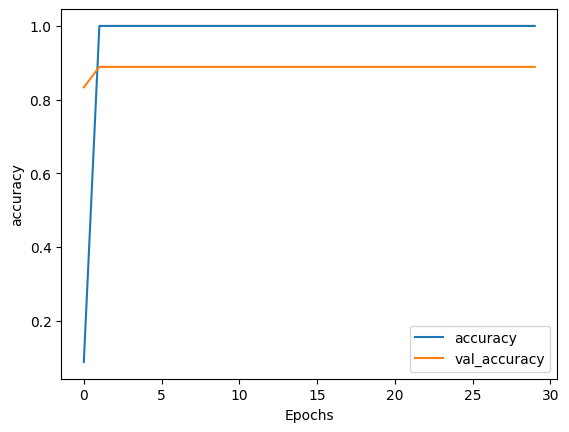

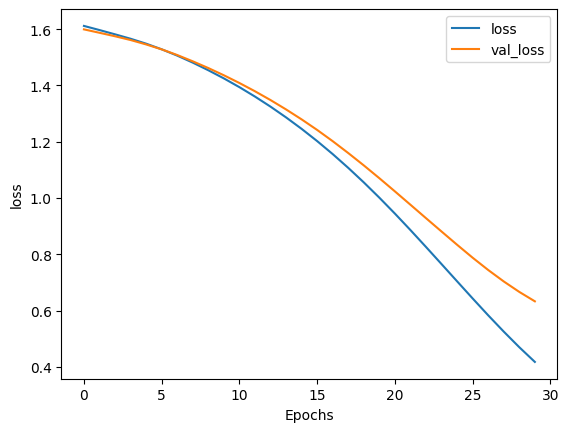

In [29]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
model.save("/content/drive/MyDrive/model2documents/model/dummyDocuments.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
